# Analysis of Building America 2015 Study

In [2]:
import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [3]:
rcParams['figure.figsize']= (10, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

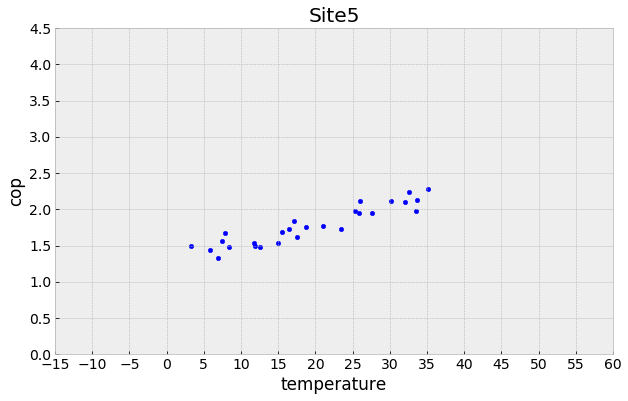

In [4]:
sheet_names = ('Site1', 'Site2', 'Site4', 'Site5', 'Site8', 'Site9', 'Site10')
ix = 3
dfp = pd.read_excel('COP_vs_temp_plots.xlsx', sheet_name=sheet_names[ix])
dfp.plot(x='temperature', y='cop', kind='scatter')
xlim(-15, 60)
ylim(0, 4.5)
title(sheet_names[ix])
gca().set_xticks(np.arange(-15, 61, 5));

In [5]:
def bin_averages(df, bin_width = 5.0):
    """For DataFrame df, calculate average temperatures and COPs for bins
    of outdoor temperature of width 'bin_width' deg F.  Return a DataFrame
    with the averaged values.
    """
    dfc = df.copy()
    # calculate the bin for each row
    dfc['temp_bin'] = dfc['temperature'] // bin_width
    
    # average by bins
    dfa = dfc.groupby('temp_bin').mean()
    dfa = dfa[['temperature', 'cop']]
    return dfa

In [6]:
# Determines width of averaging bins
BIN_WIDTH = 10./3.

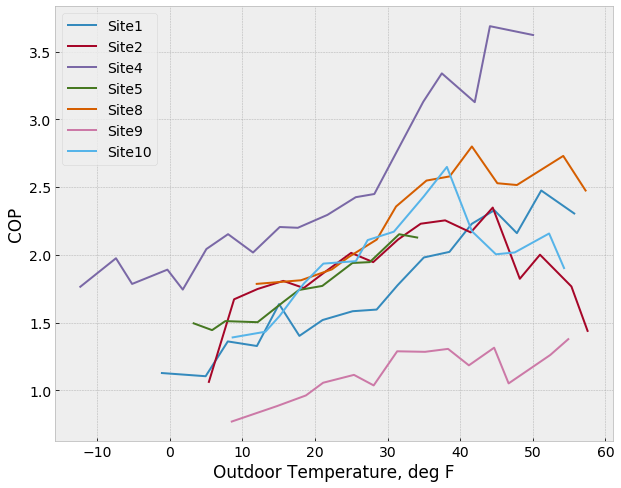

In [7]:
# Plot all the curves, but also create one DataFrame containing
# all the binned data
figure(figsize=(10,8))
df_all = None
for sht_nm in sheet_names:
    dfp = pd.read_excel('COP_vs_temp_plots.xlsx', sheet_name=sht_nm)
    dfa = bin_averages(dfp, bin_width=BIN_WIDTH)
    dfa.reset_index(inplace=True)
    dfa.drop(columns=['temp_bin'], inplace=True)
    dfa['site'] = sht_nm
    plot(dfa.temperature, dfa.cop, label=sht_nm)
    if df_all is None:
        df_all = dfa
    else:
        df_all = pd.concat([df_all, dfa])
xlabel('Outdoor Temperature, deg F')
ylabel('COP')
legend()

In [8]:
df_all.head()

,temperature,cop,site
0,-1.085000,1.127000,Site1
1,4.939500,1.103500,Site1
2,7.992500,1.360500,Site1
3,12.000833,1.326717,Site1
4,15.051429,1.636143,Site1


There is good data coverage from 10 - 50 deg F outdoors.  Except, Site 5 only has data up through about 35 deg F.  So, we will drop Site 5. 

In [9]:
# Drop Site 5
df_all.query("site != 'Site5'", inplace=True)

In [10]:
df_all.query('site == "Site4"')

,temperature,cop,site
0,-12.324443,1.764335,Site4
1,-7.412606,1.974827,Site4
2,-5.189353,1.785136,Site4
3,-0.329220,1.890654,Site4
4,1.790626,1.743438,Site4
5,5.043249,2.043033,Site4
6,8.027366,2.152769,Site4
7,11.466945,2.017199,Site4
8,15.147376,2.205641,Site4
9,17.640113,2.199940,Site4


The other problem is that Site 4 has no data in the 46.67 deg F to 50 deg F bin, as shown in the above table.  So if we use the bin_averages() function, it will ignore Site 4 in the calculation of the average for that bin, causing a large distortion since Site 4 has a high COP.  So, instead of using the bin_averages() function to combine all this data, we should just use interpolated values at the midpoint temperatures of the bin.

In [11]:
# Midpoints of the temperature bins we are interested in
temp_midpoints = np.arange(10.0 + BIN_WIDTH / 2.0, 50.0, BIN_WIDTH)
temp_midpoints

array([11.66666667, 15.        , 18.33333333, 21.66666667, 25.        ,
       28.33333333, 31.66666667, 35.        , 38.33333333, 41.66666667,
       45.        , 48.33333333])

In [14]:
# Make a DataFrame with the temperature midpoints as the index
# and each column being the COP values from a particular site.
df_mids = pd.DataFrame(index=temp_midpoints)
for site_str in df_all.site.unique():
    df_site = df_all.query('site==@site_str')
    cop_values = np.interp(temp_midpoints, df_site.temperature, df_site.cop)
    df_mids[site_str] = cop_values
        
df_mids

,Site1,Site2,Site4,Site8,Site9,Site10
11.666667,1.329533,1.737643,2.027425,1.785561,0.826022,1.418118
15.000000,1.630926,1.796922,2.198096,1.798833,0.887394,1.540905
18.333333,1.419047,1.757319,2.216144,1.817164,0.953218,1.778381
21.666667,1.528330,1.884803,2.294061,1.880227,1.062796,1.937367
25.000000,1.580619,2.014107,2.405183,1.995913,1.108378,1.950752
28.333333,1.595221,1.961537,2.465184,2.107077,1.054916,2.127493
31.666667,1.791798,2.121580,2.802517,2.379873,1.287251,2.221569
35.000000,1.980688,2.233136,3.137681,2.532192,1.283816,2.432597
38.333333,2.019677,2.244549,3.300135,2.577302,1.305295,2.627567
41.666667,2.231366,2.178456,3.143851,2.796554,1.201301,2.171825


In [51]:
series_mean = df_mids.mean(axis=1)
series_mean

11.666667    1.520717
15.000000    1.642179
18.333333    1.656879
21.666667    1.764597
25.000000    1.842492
28.333333    1.885238
31.666667    2.100765
35.000000    2.266685
38.333333    2.345754
41.666667    2.287226
45.000000    2.347374
48.333333    2.228139
dtype: float64

In [52]:
# turn Series into a DataFrame
df_all_avg = pd.DataFrame({'temperature': series_mean.index, 'cop': series_mean.values})
df_all_avg

,temperature,cop
0,11.666667,1.520717
1,15.000000,1.642179
2,18.333333,1.656879
3,21.666667,1.764597
4,25.000000,1.842492
5,28.333333,1.885238
6,31.666667,2.100765
7,35.000000,2.266685
8,38.333333,2.345754
9,41.666667,2.287226


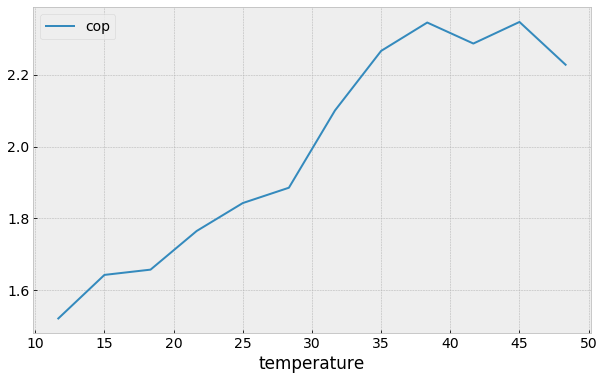

In [53]:
df_all_avg.plot(x='temperature', y='cop')

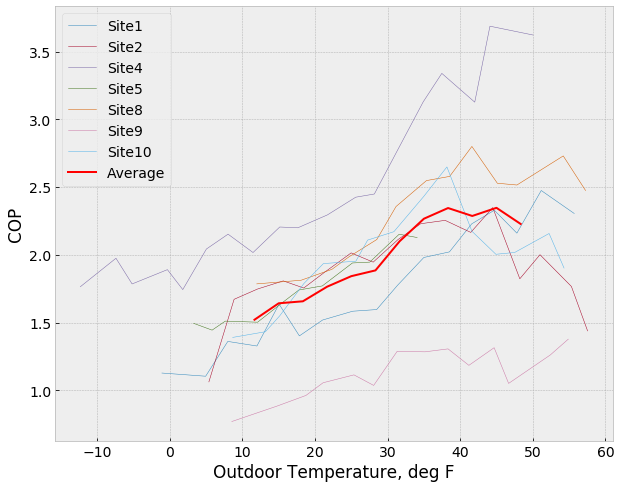

In [54]:
# Redo the plot showing all the lines, but superimpose this line on it
figure(figsize=(10,8))
df_all = None
for sht_nm in sheet_names:
    dfp = pd.read_excel('COP_vs_temp_plots.xlsx', sheet_name=sht_nm)
    dfa = bin_averages(dfp, bin_width=BIN_WIDTH)
    dfa.reset_index(inplace=True)
    dfa.drop(columns=['temp_bin'], inplace=True)
    dfa['site'] = sht_nm
    plot(dfa.temperature, dfa.cop, label=sht_nm, linewidth=0.5)
    if df_all is None:
        df_all = dfa
    else:
        df_all = pd.concat([df_all, dfa])
plot(df_all_avg.temperature, df_all_avg.cop, 'r-', linewidth=2.0, label='Average')
xlabel('Outdoor Temperature, deg F')
ylabel('COP')
legend()

In [55]:
# Calculate weighted average of HSPF values for the studied 
# units.  I dropped Site 5, which was the one Fujit 15RLS2 studied.
# So:  3 Mitsu FE18 + 3 Mitsu FE12
(3 * 10.3 + 3 * 10.5) / 6.0

10.4

In [56]:
df_all_avg['source'] = 'Steven Winter'
df_all_avg['field_study'] = True
df_all_avg['hspf'] = 10.4   # Estimate at this point
df_all_avg.to_pickle('temp_cop_swinter.pkl')